# Run QU fitting for selected points for tadpole paper
## A. Ordog, Nov. 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import ICRS    
from astropy.coordinates import Galactic 
from astropy.coordinates import SkyCoord 
import json
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean

## Change below to True if want to run the QU fitting (existing files will be overwritten)

In [2]:
run_fitting = True
#directory = '/srv/data/chime/tadpole_cutout/QU_fitting_results/'
directory = '/srv/data/chime/tadpole_cutout_Mar2024/QU_fitting_results/'

## Read in files

In [3]:
#hduQ = fits.open('/srv/data/chime/tadpole_cutout/IQU_400_729/Q_400_729_Oct2023_tadpole_gal.fits')
#hduU = fits.open('/srv/data/chime/tadpole_cutout/IQU_400_729/U_400_729_Oct2023_tadpole_gal.fits')
#hduI = fits.open('/srv/data/chime/tadpole_cutout/IQU_400_729/I_400_729_Oct2023_tadpole_gal.fits')

hduQ = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/IQUV_400_729/Q_400_729_Mar2024_tadpole_gal.fits')
hduU = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/IQUV_400_729/U_400_729_Mar2024_tadpole_gal.fits')
hduI = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/IQUV_400_729/I_400_729_Oct2023_tadpole_gal.fits')

## Make arrays and headers

In [4]:
Q = hduQ[0].data
U = hduU[0].data
I = hduI[0].data

hdr = hduQ[0].header

hdr2D = hdr.copy()
hdr2D['NAXIS'] = 2
hdr2D['WCSAXES'] = 2
for card in hdr.cards:
    try:
        if card[0][5] == '3':
            del hdr2D[card[0]]
    except:
        pass
    
freq = WCS(hdr).all_pix2world(0,0,range(Q.shape[0]),0)[2]
print(freq[0],freq[-1])

729687500.0 400390625.0


## Functions

In [5]:
def make_QU_input_files(i,j):

    w = np.where(np.isfinite(Q[:,j,i]) & np.isfinite(U[:,j,i]) & np.isfinite(I[:,j,i]))[0]
    Qlist = Q[:,j,i]/I[:,j,i]
    Ulist = U[:,j,i]/I[:,j,i]
    Qerr = np.ones_like(Qlist)*0.01
    Uerr = np.ones_like(Ulist)*0.01

    out_array = np.column_stack((freq[w],Qlist[w],Ulist[w],Qerr[w],Uerr[w]))

    file_name = directory+filename+'.dat'
    np.savetxt(file_name, out_array, delimiter=" ",fmt=['%0.1f']+['%0.5f']*4)
    
    return

## Pick coordinates

296 614062500.0
103 136
137.0625 7.0625
128 133
133.9375 6.6875
120 156
134.9375 9.5625


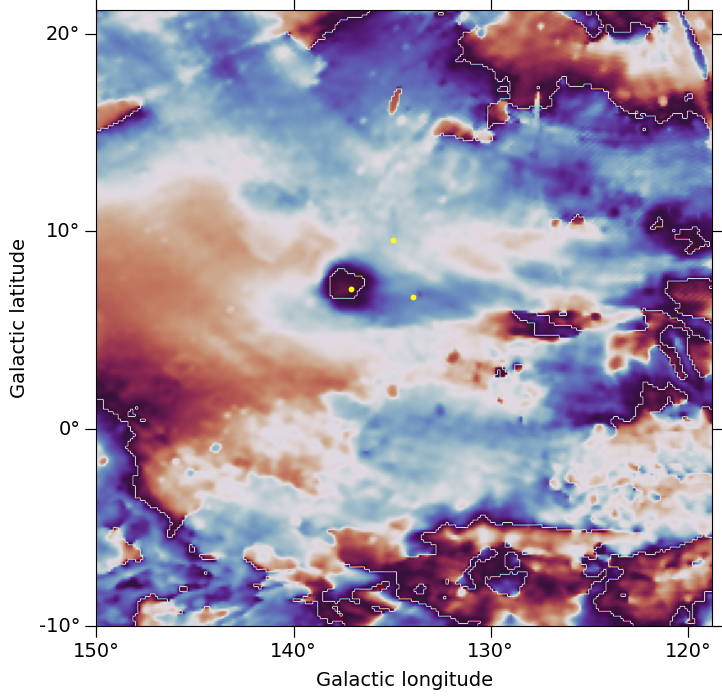

In [6]:
###############
freq_plot = 614e6
paper_points = True
point_list = 'tadpole_paper_points.dat'
#point_list = 'tadpole_points_extra.dat'
#point_list = 'tadpole_points.dat'
###############

fig = plt.figure(figsize=(12,8))

idx = WCS(hdr).wcs_world2pix(0,0,freq_plot,0)[2]
idx = int(np.round(idx,0))
print(idx, freq[idx])

ax = fig.add_subplot(111, projection=WCS(hdr2D).celestial)
im = ax.imshow(0.5*np.arctan2(U[idx],Q[idx]),origin='lower',
               vmin=-np.pi/2,vmax=np.pi/2,cmap='twilight_shifted',interpolation=None)

if paper_points:  
    lon = []
    lat = []
    cat = [1,2,3]
    #i_list = [103,128,120]
    #j_list = [138,133,156]
    i_list = [103,128,120]
    j_list = [136,133,156] 
    for ii in range(0,len(i_list)):
        coords = WCS(hdr2D).pixel_to_world(i_list[ii],j_list[ii])
        print(i_list[ii],j_list[ii])
        print(coords.l.deg,coords.b.deg)
        ax.scatter(i_list[ii],j_list[ii],s=10,color='yellow')
        lon.append(coords.l.deg)
        lat.append(coords.b.deg)       
    file_name = directory+point_list
        
else:
    ############
    lon_head = [136.5,136.5,136.5,136.5,137,137,137,137,
                137.5,137.5,137.5,137.5,138,138,138,138]
    lat_head = [6.5,7,7.5,8,6.5,7,7.5,8,6.5,7,7.5,8,6.5,7,7.5,8]
    lon_tail = [136,135,134,133,132,131,130,136,135,134,133,132,131,130]
    lat_tail = [7,7,7,7,7,7,7,6.5,6.5,6.5,6.5,6.5,6.5,6.5]
    lon_off = [140,140,140,137,136,135,134,133,132,137,136,135,134,133,132]
    lat_off = [8,7,6,4.5,4.5,4.5,4.5,4.5,4.5,9,9,9,9,9,9]
    # Additional points that we added later on:
    lon_more = [136,135,134,133,132,131]
    lat_more = [6,5.5,6,6,6,6]
    cat_more = [2,2,2,2,2,2]
    
    lon = lon_head+lon_tail+lon_off+lon_more
    lat = lat_head+lat_tail+lat_off+lat_more
    #cat = [1]*len(lon_head)+[2]*len(lon_tail)+[3]*len(lon_off)
    cat = [1]*len(lon_head)+[2]*len(lon_tail)+[3]*len(lon_off)+cat_more
    ############
    for ii in range(0,len(lon)):
        c = SkyCoord(lon[ii], lat[ii], frame=Galactic, unit="deg")
        pixels = WCS(hdr2D).world_to_pixel(c)
        i = int(np.round(pixels[0],0))
        j = int(np.round(pixels[1],0))
        ax.scatter(i,j,s=10,color='yellow')       
    file_name = directory+point_list

ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel('Galactic latitude',fontsize=14)
ax.set_xlabel('Galactic longitude',fontsize=14)

out_array = np.column_stack((lon,lat,cat))

if run_fitting:
    np.savetxt(file_name, out_array, delimiter=" ",fmt=['%f']*2+['%d'])

## Run the four models for all points:

In [8]:
if run_fitting:

    for ii in range(0,len(lon)):
    #for ii in range(31,len(lon)):
        c = SkyCoord(lon[ii], lat[ii], frame=Galactic, unit="deg")
        pixels = WCS(hdr2D).world_to_pixel(c)
        i = int(np.round(pixels[0],0))
        j = int(np.round(pixels[1],0))

        filename = 'lon'+"{:.1f}".format(lon[ii])+'_lat'+"{:.1f}".format(lat[ii])

        make_QU_input_files(i,j)


        print('=======================================================')
        print(ii+1, 'of',len(lon),':',filename, ' one-component model')
        print('=======================================================')
        print('')
        cmd = 'qufit '+directory+filename+'.dat -m 1 --sampler=pymultinest'
        print(cmd)
        print('')
        !{cmd}

        print('=======================================================')
        print(ii+1, 'of',len(lon),':',filename, ' two-component model')
        print('=======================================================')
        print('')
        cmd = 'qufit '+directory+filename+'.dat -m 11 --sampler=pymultinest'
        print(cmd)
        print('')
        !{cmd}

        print('=======================================================')
        print(ii+1, 'of',len(lon),':',filename, ' one-component Burn model')
        print('=======================================================')
        print('')
        cmd = 'qufit '+directory+filename+'.dat -m 2 --sampler=pymultinest'
        print(cmd)
        print('')
        !{cmd}

        print('=======================================================')
        print(ii+1, 'of',len(lon),':',filename, ' two-component Burn model')
        print('=======================================================')
        print('')
        cmd = 'qufit '+directory+filename+'.dat -m 4 --sampler=pymultinest'
        print(cmd)
        print('')
        !{cmd}


1 of 3 : lon137.1_lat7.1  one-component model

qufit /srv/data/chime/tadpole_cutout_Mar2024/QU_fitting_results/lon137.1_lat7.1.dat -m 1 --sampler=pymultinest


Format [freq_Hz, Q, U,  dQ, dU]
Note: no Stokes I data - assuming fractional polarisation.
Plotting the input data and spectral index fit.
Imodel:0.0,0.0,0.0,0.0,0.0,1.0
Imodel_errs:0.0,0.0,0.0,3.8037655,0.31950805,0.07038427
IfitChiSq:0.0
IfitChiSqRed:0.0
IfitPolyOrd:2
Ifitfreq0:580140035.2

Loading the model from 'models_ns/m1.py' ...
12:30 bilby INFO    : Running for label 'm1', output will be saved to '/srv/data/chime/tadpole_cutout_Mar2024/QU_fitting_results/lon137.1_lat7.1_m1_pymultinest/'
12:30 bilby INFO    : Analysis priors:
12:30 bilby INFO    : fracPol=Uniform(minimum=0.001, maximum=1.0, name='fracPol', latex_label='$p$', unit=None, boundary=None)
12:30 bilby INFO    : psi0_deg=Uniform(minimum=0, maximum=180.0, name='psi0_deg', latex_label='$\\psi_0$ (deg)', unit=None, boundary='periodic')
12:30 bilby INFO    : RM_rad